In [1]:
from datasets import load_dataset

num_samples_to_take = 100
ds = load_dataset("sayeed99/fashion_segmentation", split="train",streaming=True)
ds = ds.take(num_samples_to_take)

/home/ash/Projects/FashionSeg/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds

IterableDataset({
    features: ['image', 'label'],
    num_shards: 53
})

In [3]:
sample = next(iter(ds))
sample['image'] , sample['label']

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3676x5214>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=3676x5214>)

Text(0.5, 1.0, 'Segmentation Label')

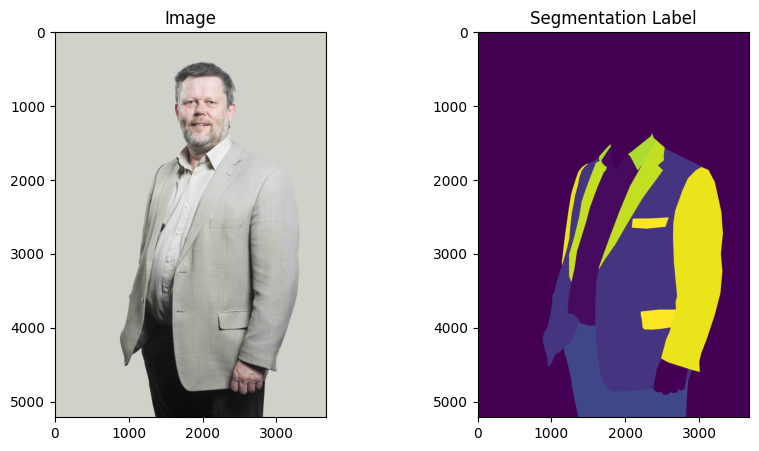

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample['image'])
ax[0].set_title('Image')    
ax[1].imshow(sample['label'])   
ax[1].set_title('Segmentation Label')

In [17]:
import random
import numpy as np

def plot_random_sample(dataset):
    skip_n = random.randint(0, num_samples_to_take - 1)
    sample = next(iter(dataset.skip(skip_n)))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(sample['image'])
    ax[0].set_title('Image')    
    ax[1].imshow(sample['label'])   
    ax[1].set_title('Segmentation Label')
    print(np.unique(np.array(sample['label'])))
    plt.show()


[ 0  1  5  7 17 29 30 32 33]


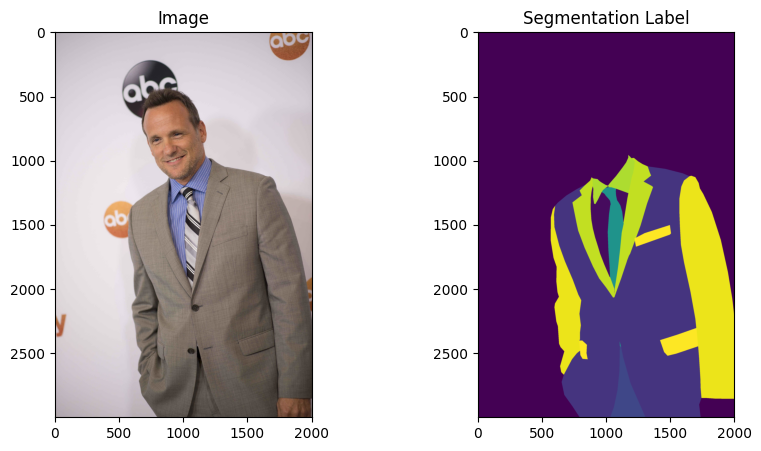

In [19]:
plot_random_sample(ds)

[ 0 11 22 24 34]


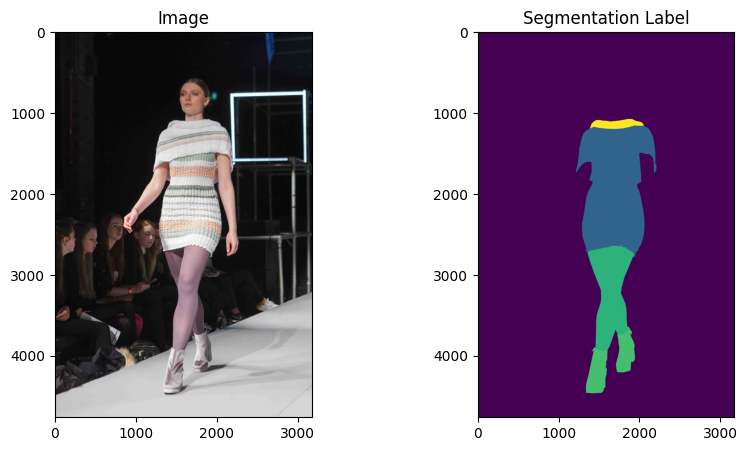

In [20]:
plot_random_sample(ds)

Class 1: 847796 pixels
Class 5: 2817303 pixels
Class 7: 883261 pixels
Class 29: 90310 pixels
Class 30: 494904 pixels
Class 32: 1566584 pixels
Class 33: 169658 pixels


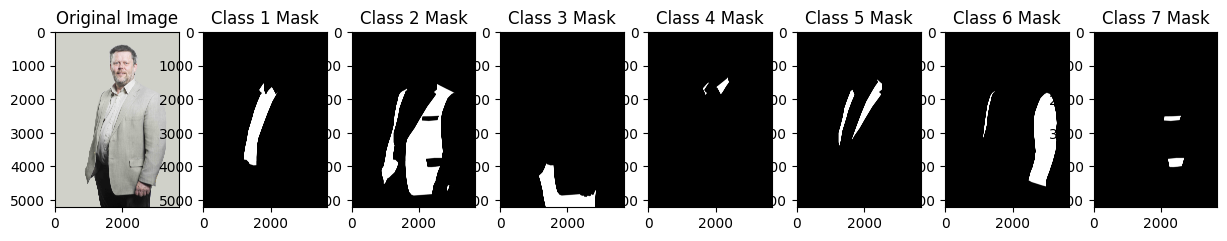

In [21]:
def extract_class_mask(mask):
    mask = np.array(mask)
    class_ids = np.unique(mask)
    
    class_ids = class_ids[class_ids != 0]

    binary_masks = []
    for class_id in class_ids:
        binary_mask = (mask == class_id).astype(np.uint8)
        binary_masks.append(binary_mask)
        print(f"Class {class_id}: {np.sum(binary_mask)} pixels")

    return binary_masks

sample = next(iter(ds))
mask = sample["label"]

binary_masks = extract_class_mask(mask)
fig, axes = plt.subplots(1, len(binary_masks)+1, figsize=(15, 5))
axes[0].imshow(sample["image"])
axes[0].set_title("Original Image")

for i, bm in enumerate(binary_masks):
    axes[i+1].imshow(bm, cmap="gray")
    axes[i+1].set_title(f"Class {i+1} Mask")

plt.show()

Class 1 point prompt: (2549, 1522)


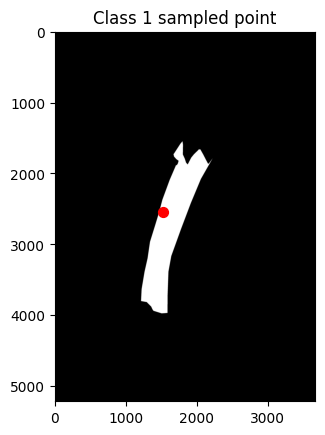

Class 2 point prompt: (1817, 2626)


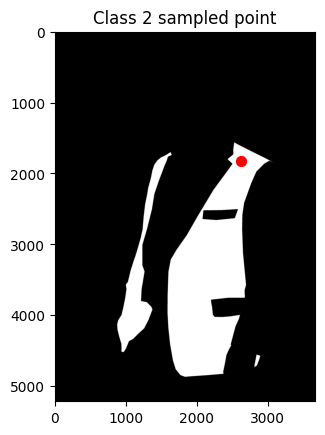

Class 3 point prompt: (4766, 1357)


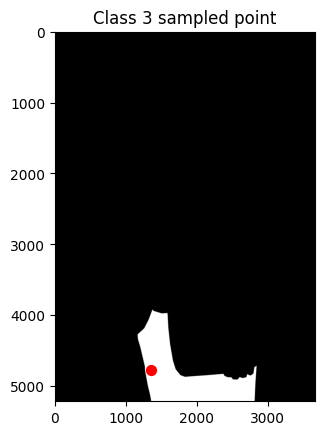

Class 4 point prompt: (1637, 2109)


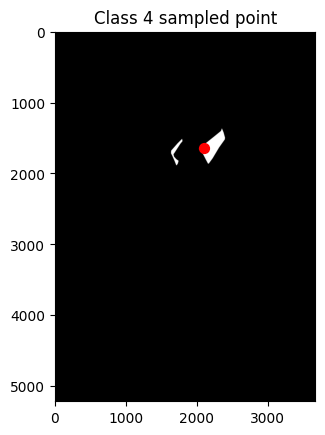

Class 5 point prompt: (2119, 1547)


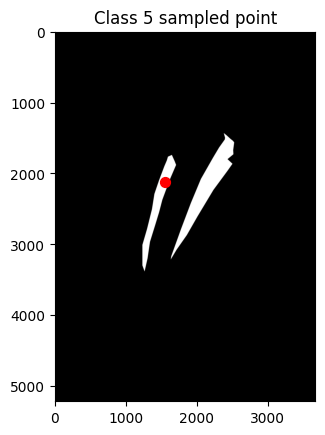

Class 6 point prompt: (2566, 3174)


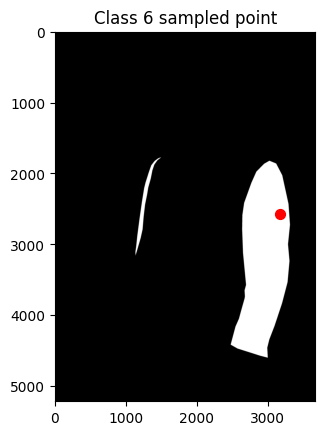

Class 7 point prompt: (2641, 2439)


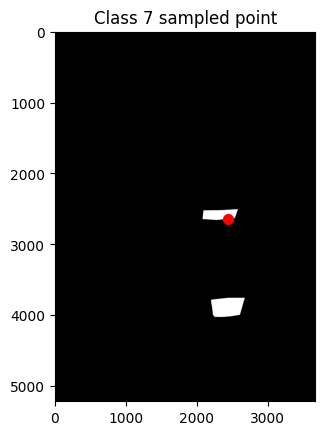

In [13]:
def sample_point_from_mask(binary_mask):
    ys, xs = np.where(binary_mask == 1)
    if len(xs) == 0:
        return None  # no foreground pixels found
    
    idx = random.randint(0, len(xs) - 1)
    y, x = ys[idx], xs[idx]
    return (y, x)

for i, mask in enumerate(binary_masks):
    point = sample_point_from_mask(mask)
    print(f"Class {i+1} point prompt:", point)

    if point is not None:
        plt.imshow(mask, cmap="gray")
        plt.scatter(point[1], point[0], c="red", s=50)
        plt.title(f"Class {i+1} sampled point")
        plt.show()

In [22]:
def extract_class_masks(mask):
    mask = np.array(mask)
    class_ids = np.unique(mask)
    class_ids = class_ids[class_ids != 0]  # exclude background
    binary_masks = [(mask == cid).astype(np.uint8) for cid in class_ids]
    return binary_masks, class_ids

def visualize_point_and_mask(sample):
    image = np.array(sample["image"])
    mask = np.array(sample["label"])
    
    binary_masks, class_ids = extract_class_masks(mask)
    
    idx = random.randint(0, len(binary_masks) - 1)
    binary_mask = binary_masks[idx]
    class_id = class_ids[idx]
    
    point = sample_point_from_mask(binary_mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image)
    if point is not None:
        axes[1].scatter(point[1], point[0], c='red', s=60, marker='*', edgecolors='white')
    axes[1].set_title(f"Sampled Point (Class {class_id})")
    axes[1].axis("off")
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f"Binary Mask for Class {class_id}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

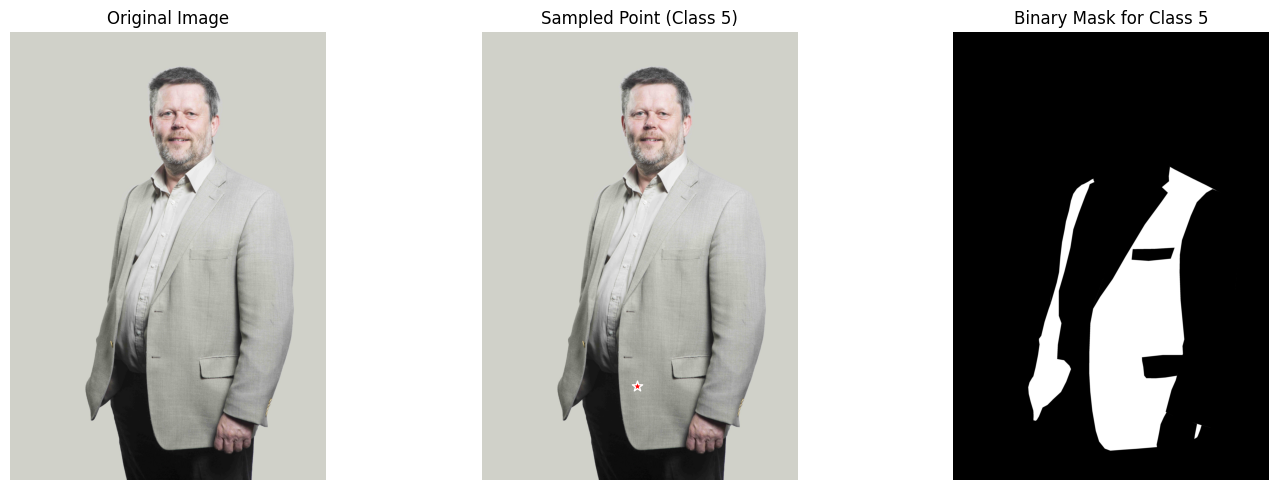

In [23]:
sample = next(iter(ds))
visualize_point_and_mask(sample)

### Convert dataset to SAM format

In [24]:
from tqdm import tqdm

In [25]:
def prepare_sam_training_data(dataset, max_samples=100):
    processed_data = []

    for i, sample in enumerate(tqdm(dataset, total=max_samples, desc="Preparing data")):
        if i >= max_samples:
            break

        image = np.array(sample["image"])
        mask = np.array(sample["label"])

        binary_masks, class_ids = extract_class_masks(mask)

        for class_id, binary_mask in zip(class_ids, binary_masks):
            point = sample_point_from_mask(binary_mask)
            if point is None:
                continue

            processed_data.append({
                "image": image,
                "mask": binary_mask,
                "point": point,
                "class_id": int(class_id)
            })

    return processed_data


In [26]:
num_samples_to_take = 50
ds = load_dataset("sayeed99/fashion_segmentation", split="train", streaming=True)
ds = ds.take(num_samples_to_take)

sam_data = prepare_sam_training_data(ds, max_samples=num_samples_to_take)
print(f"Prepared {len(sam_data)} training samples")

Preparing data:  84%|████████▍ | 42/50 [00:14<00:00, 10.25it/s]

: 